In [13]:
import sqlite3
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense

In [14]:
import sqlite3
import pandas as pd

# Remplacez "ma_base_de_donnees.db" par le nom de votre base de données SQLite
nom_base_de_donnees = "ma_base_de_donnees.db"

# Colones que vous souhaitez récupérer
colonne1 = "Good_chords"
colonne2 = "notes"

# Initialisation d'un DataFrame vide
df = pd.DataFrame()

# Connexion à la base de données
connexion = sqlite3.connect(nom_base_de_donnees)

# Obtenez la liste des tables disponibles dans la base de données
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, connexion)['name']

# Boucle à travers les tables et récupération des données
for nom_table in tables:
    requete_sql = f"SELECT {colonne1}, {colonne2} FROM \"{nom_table}\""
    table_df = pd.read_sql_query(requete_sql, connexion)
    
    # Fusionner le DataFrame actuel avec le DataFrame de la table courante
    df = pd.concat([df, table_df], ignore_index=True)

# Affichage du DataFrame combiné
print(df)

# Fermeture de la connexion
connexion.close()


     Good_chords                       notes
0             NM                         nan
1             EM            ['E', 'G#', 'B']
2             AM            ['A', 'C#', 'E']
3             EM            ['E', 'G#', 'B']
4             BM           ['B', 'D#', 'F#']
...          ...                         ...
1006          AM            ['A', 'C#', 'E']
1007          AM            ['A', 'C#', 'E']
1008          DM            ['D', 'F#', 'A']
1009          D9  ['D', 'F#', 'A', 'C', 'E']
1010          NM                         nan

[1011 rows x 2 columns]


In [15]:
df['notes'] = df['notes'].str.replace(' ','')
df.head()

,Good_chords,notes
0,NM,nan
1,EM,"['E','G#','B']"
2,AM,"['A','C#','E']"
3,EM,"['E','G#','B']"
4,BM,"['B','D#','F#']"


In [16]:
import numpy as np
long = []

for val in df['notes']:
    long.append(len(val))

np.max(long)

25

In [17]:
import re
import tensorflow as tf

max_features = 25
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=',')
tokenizer.fit_on_texts(df['notes'].values)
X = tokenizer.texts_to_sequences(df['notes'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(1011, 9)

In [18]:
import numpy as np
nb_classe = len(np.unique(df['Good_chords']))
classes = np.unique(df['Good_chords'])

In [19]:
from sklearn.model_selection import train_test_split
import numpy as np
Y = pd.get_dummies(df['Good_chords'])
Y = Y.values

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(677, 9) (677, 45)
(334, 9) (334, 45)


In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Hyperparameters to test
hyperparameters_list_emb = [300, 250, 200, 150, 100, 50]
hyperparameters_list_lstm = [256, 196, 128, 64]

accuracy_results = []
history = []

# Loop over different values of hyperparameters
for embed_dim in hyperparameters_list_emb:
    for lstm_out in hyperparameters_list_lstm:
            # Create the model with the current hyperparameter values
            model = tf.keras.Sequential([
                tf.keras.layers.Embedding(max_features, embed_dim, input_length=X.shape[1]),
                tf.keras.layers.SpatialDropout1D(0.4),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, recurrent_dropout=0.2)),
                tf.keras.layers.Dense(nb_classe, activation='softmax')
            ])
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Train the model with the training data
            history.append(model.fit(X_train, Y_train, epochs=20, verbose=0, validation_split=0.3))

            # Evaluate the model on the test data
            score, acc = model.evaluate(X_test, Y_test, verbose=2)

            # Store the accuracy result in the list
            accuracy_results.append((embed_dim, lstm_out, acc))

# Display the results
for embed_dim, lstm_out, accuracy in accuracy_results:
    print(f"Embedding Dimension: {embed_dim}, LSTM Units: {lstm_out}, Batch Size: {batch_size}, Accuracy: {accuracy}")

11/11 - 0s - loss: 0.4832 - accuracy: 0.9641 - 296ms/epoch - 27ms/step
11/11 - 0s - loss: 0.4845 - accuracy: 0.9641 - 306ms/epoch - 28ms/step
11/11 - 0s - loss: 0.4057 - accuracy: 0.9641 - 190ms/epoch - 17ms/step
11/11 - 0s - loss: 0.3543 - accuracy: 0.9611 - 259ms/epoch - 24ms/step
11/11 - 0s - loss: 0.5134 - accuracy: 0.9641 - 154ms/epoch - 14ms/step
11/11 - 0s - loss: 0.4251 - accuracy: 0.9641 - 172ms/epoch - 16ms/step
11/11 - 0s - loss: 0.4215 - accuracy: 0.9641 - 258ms/epoch - 23ms/step
11/11 - 0s - loss: 0.4097 - accuracy: 0.9521 - 341ms/epoch - 31ms/step
11/11 - 0s - loss: 0.4716 - accuracy: 0.9641 - 340ms/epoch - 31ms/step
11/11 - 0s - loss: 0.4852 - accuracy: 0.9641 - 262ms/epoch - 24ms/step
11/11 - 0s - loss: 0.4481 - accuracy: 0.9641 - 207ms/epoch - 19ms/step
11/11 - 0s - loss: 0.3990 - accuracy: 0.9551 - 109ms/epoch - 10ms/step
11/11 - 0s - loss: 0.4548 - accuracy: 0.9641 - 203ms/epoch - 18ms/step
11/11 - 0s - loss: 0.4679 - accuracy: 0.9641 - 199ms/epoch - 18ms/step
11/11 

ValueError: not enough values to unpack (expected 4, got 3)

In [23]:
for embed_dim, lstm_out, accuracy in accuracy_results:
    print(f"Embedding Dimension: {embed_dim}, LSTM Units: {lstm_out}, Accuracy: {accuracy}")

Embedding Dimension: 300, LSTM Units: 256, Accuracy: 0.9640718698501587
Embedding Dimension: 300, LSTM Units: 196, Accuracy: 0.9640718698501587
Embedding Dimension: 300, LSTM Units: 128, Accuracy: 0.9640718698501587
Embedding Dimension: 300, LSTM Units: 64, Accuracy: 0.961077868938446
Embedding Dimension: 250, LSTM Units: 256, Accuracy: 0.9640718698501587
Embedding Dimension: 250, LSTM Units: 196, Accuracy: 0.9640718698501587
Embedding Dimension: 250, LSTM Units: 128, Accuracy: 0.9640718698501587
Embedding Dimension: 250, LSTM Units: 64, Accuracy: 0.9520958065986633
Embedding Dimension: 200, LSTM Units: 256, Accuracy: 0.9640718698501587
Embedding Dimension: 200, LSTM Units: 196, Accuracy: 0.9640718698501587
Embedding Dimension: 200, LSTM Units: 128, Accuracy: 0.9640718698501587
Embedding Dimension: 200, LSTM Units: 64, Accuracy: 0.955089807510376
Embedding Dimension: 150, LSTM Units: 256, Accuracy: 0.9640718698501587
Embedding Dimension: 150, LSTM Units: 196, Accuracy: 0.96407186985015

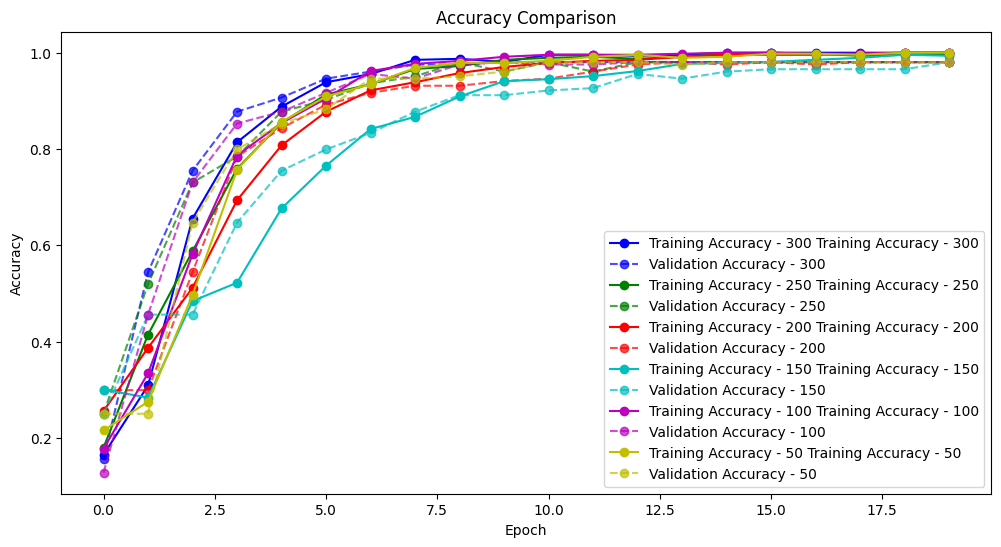

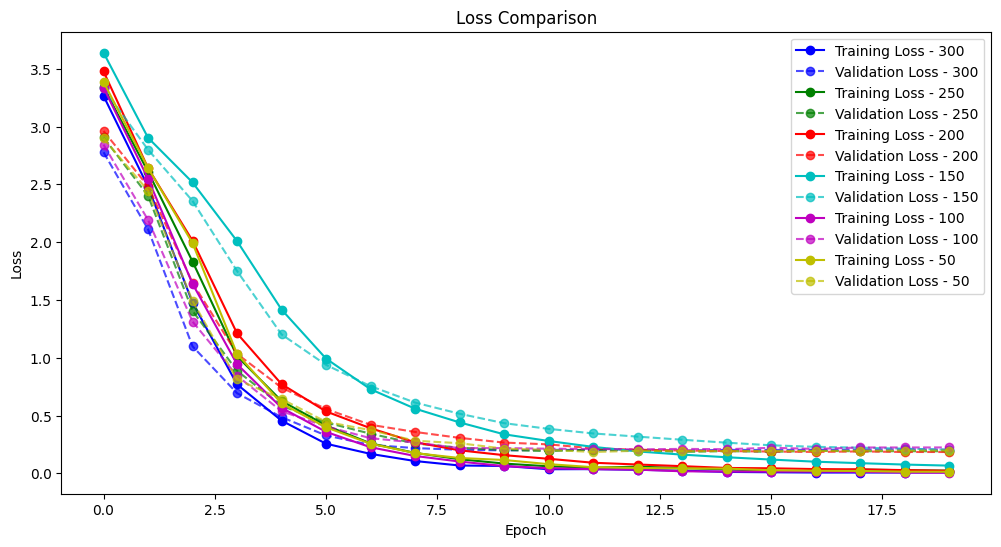

In [24]:
import matplotlib.pyplot as plt

# ... (your code)

# Define a list of colors for each hyperparameter
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plotting the training history for each hyperparameter on the same graph
plt.figure(figsize=(12, 6))

# Plotting Accuracy
for i, hyperparameter_value in enumerate(hyperparameters_list_emb):
    color = colors[i % len(colors)]  # Cycle through colors
    plt.plot(history[i].history['accuracy'], label=f'Training Accuracy - {hyperparameter_value} Training Accuracy - {hyperparameter_value}', linestyle='-', marker='o', color=color)
    plt.plot(history[i].history['val_accuracy'], label=f'Validation Accuracy - {hyperparameter_value}', linestyle='--', marker='o', color=color, alpha=0.7)  # Use alpha to make validation curve slightly transparent

# Configure Accuracy Plot
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.figure(figsize=(12, 6))

# Plotting Loss
for i, hyperparameter_value in enumerate(hyperparameters_list_emb):
    color = colors[i % len(colors)]  # Cycle through colors
    plt.plot(history[i].history['loss'], label=f'Training Loss - {hyperparameter_value}', linestyle='-', marker='o', color=color)
    plt.plot(history[i].history['val_loss'], label=f'Validation Loss - {hyperparameter_value}', linestyle='--', marker='o', color=color, alpha=0.7)  # Use alpha to make validation curve slightly transparent

# Configure Loss Plot
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


In [ ]:
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=64)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

6/6 - 0s - loss: 0.5064 - accuracy: 0.9611 - 116ms/epoch - 19ms/step
score: 0.51
acc: 0.96


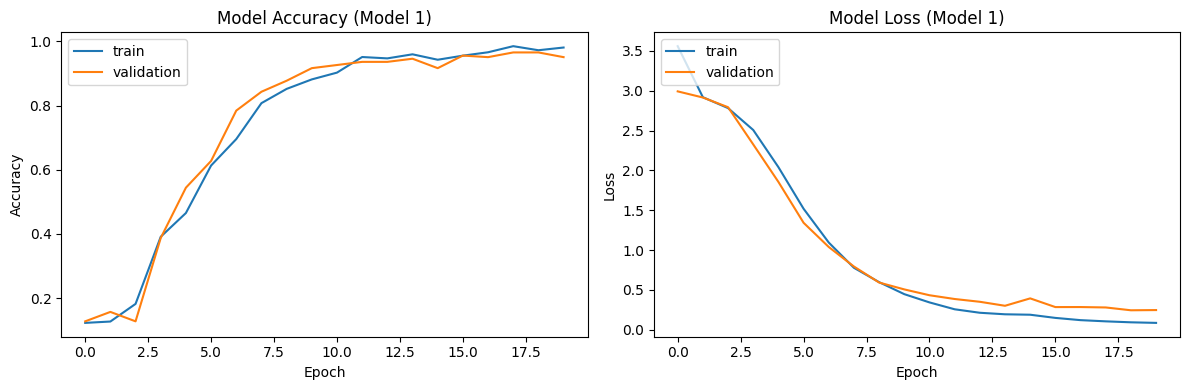

In [ ]:
import matplotlib.pyplot as plt

# Créez une figure avec une grille de sous-graphiques 1x2
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Ajustez la taille de la figure selon vos besoins

# Premier sous-graphique (précisez le nombre d'époques dans 'range(len(history1['accuracy']))')
axs[0].plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='train')
axs[0].plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='validation')
axs[0].set_title('Model Accuracy (Model 1)')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

axs[1].plot(range(len(history.history['loss'])), history.history['loss'], label='train')
axs[1].plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='validation')
axs[1].set_title('Model Loss (Model 1)')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez la figure
plt.show()